CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-7., 7.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transforms)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 500kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.97MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.08MB/s]


CODE BLOCK: 5

In [5]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


CODE BLOCK: 6

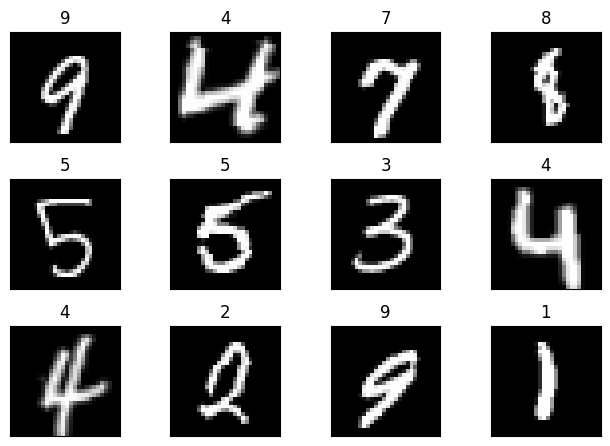

In [6]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NetOptimized(nn.Module):
    def __init__(self):
        super(NetOptimized, self).__init__()

        # --- BLOCK 1 ---
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 14, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(14)
        self.conv3 = nn.Conv2d(14, 20, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(20)
        self.pool1 = nn.MaxPool2d(2,2)
        self.drop1 = nn.Dropout2d(0.05)

        # --- BLOCK 2 ---
        self.conv4 = nn.Conv2d(20, 24, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(24, 20, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(20)
        self.pool2 = nn.MaxPool2d(2,2)
        self.drop2 = nn.Dropout2d(0.1)

        # --- BLOCK 3 ---
        self.conv6 = nn.Conv2d(20, 20, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(20)
        self.conv7 = nn.Conv2d(20, 16, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(16)
        self.drop3 = nn.Dropout2d(0.1)

        # --- GAP + Classifier ---
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Conv2d(16, 10, 1)

    def forward(self, x):
        # BLOCK 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(x)
        x = self.drop1(x)

        # BLOCK 2
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool2(x)
        x = self.drop2(x)

        # BLOCK 3
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.drop3(x)

        # GAP + Classifier
        x = self.gap(x)
        x = self.classifier(x)
        x = torch.flatten(x, 1)
        return F.log_softmax(x, dim=1)

In [30]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# model = Net().to(device)
model = NetOptimized().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
       BatchNorm2d-2           [-1, 10, 28, 28]              20
            Conv2d-3           [-1, 14, 28, 28]           1,274
       BatchNorm2d-4           [-1, 14, 28, 28]              28
            Conv2d-5           [-1, 20, 28, 28]           2,540
       BatchNorm2d-6           [-1, 20, 28, 28]              40
         MaxPool2d-7           [-1, 20, 14, 14]               0
         Dropout2d-8           [-1, 20, 14, 14]               0
            Conv2d-9           [-1, 24, 14, 14]           4,344
      BatchNorm2d-10           [-1, 24, 14, 14]              48
           Conv2d-11           [-1, 20, 14, 14]           4,340
      BatchNorm2d-12           [-1, 20, 14, 14]              40
        MaxPool2d-13             [-1, 20, 7, 7]               0
        Dropout2d-14             [-1, 2

CODE BLOCK: 8

In [15]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [16]:
from tqdm import tqdm
import torch
import torch.nn.functional as F

def GetCorrectPredCount(pPrediction, pLabels):
    """
    pPrediction: Tensor of shape [batch_size, num_classes]
        Example: [[2.5, 0.3, -1.0],   # sample 1 logits
                  [-1.0, 0.3, 2.5]]   # sample 2 logits

    pLabels: Tensor of shape [batch_size]
        Example: [0, 2]   # true labels (class indices)

    Process:
      1. pPrediction.argmax(dim=1) → picks class with max logit per sample
         Example: [0, 2]
      2. Compare with pLabels → [True, True]
      3. Sum → number of correct predictions (2 in this case)

    Returns:
      Integer: number of correct predictions in this batch
    """
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
    model.train()  # Enable training mode (dropout/batchnorm active)
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        """
        batch_idx: integer, index of the current batch (0, 1, 2, ...)
        data: tensor of shape [batch_size, channels, height, width]
              Example: [64, 1, 28, 28] for MNIST batch of 64 images
              data[0] = first image in batch, shape [1,28,28]
        target: tensor of shape [batch_size]
                Example: [5, 0, 3, ...] labels for each image in the batch
        This line fetches a **single batch** from the DataLoader each iteration.
        """

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Reset gradients from previous step

        # 1️⃣ Forward pass: model transforms input → logits
        # Internal call: model(data) → triggers model.forward(data)
        pred = model(data)
        # Example shapes:
        # data: [2,1,28,28], pred: [2,10] (2 images, 10 classes)
        # Each row in pred = raw scores (logits) for each class

        # 2️⃣ Compute loss
        # criterion = nn.CrossEntropyLoss()
        # Internally:
        #    - softmax(pred) → probabilities
        #    - negative log likelihood of true class
        # Example:
        # pred[0] = [2.5, 0.3, -1.0, ...] (logits)
        # target[0] = 0
        # -log(softmax(pred[0])[0]) = contribution to loss check about softmax here: https://www.notion.so/Vision-a80ad2dc4f88489bb3ecc45eac005ea2?source=copy_link#2692ba0a615b808b87a1d7d9d5d0da0c
        loss = criterion(pred, target)
        train_loss += loss.item()  # accumulate scalar loss

        # 3️⃣ Backward pass: compute gradients
        loss.backward()

        # 4️⃣ Optimizer step: update weights
        optimizer.step()

        # 5️⃣ Track training accuracy
        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        # Update progress bar
        pbar.set_description(desc=f'Train: Loss={loss.item():0.4f} '
                                   f'Batch_id={batch_idx} '
                                   f'Accuracy={100*correct/processed:0.2f}')

    # Store epoch-level metrics
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()  # Evaluation mode (dropout/batchnorm frozen)

    test_loss = 0
    correct = 0

    with torch.no_grad():  # Disable gradient computation
        for batch_idx, (data, target) in enumerate(test_loader):
            """
            Forward pass only (no backward):
              - Compute output logits for the batch
              - Do not compute gradients (no memory overhead)
            batch_idx: index of batch
            data: [batch_size, channels, height, width]
            target: [batch_size] true labels
            """

            data, target = data.to(device), target.to(device)

            # 1️⃣ Forward pass only (no weight updates)
            output = model(data)
            # output shape: [batch_size, num_classes]
            # Each row = logits for that image

            # 2️⃣ Compute batch loss
            test_loss += criterion(output, target).item()

            # 3️⃣ Count correct predictions
            correct += GetCorrectPredCount(output, target)

    # Average test loss across all samples
    test_loss /= len(test_loader.dataset)

    # Test accuracy
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [ ]:
device = 'cuda'
model = NetOptimized().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  # scheduler.step()

Epoch 1


Train: Loss=0.1225 Batch_id=468 Accuracy=89.23: 100%|██████████| 469/469 [00:20<00:00, 22.74it/s]


Test set: Average loss: 0.0007, Accuracy: 9715/10000 (97.15%)

Epoch 2


Train: Loss=0.0647 Batch_id=468 Accuracy=96.42: 100%|██████████| 469/469 [00:21<00:00, 22.31it/s]


Test set: Average loss: 0.0004, Accuracy: 9852/10000 (98.52%)

Epoch 3


Train: Loss=0.0659 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]


Test set: Average loss: 0.0003, Accuracy: 9888/10000 (98.88%)

Epoch 4


Train: Loss=0.0311 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:19<00:00, 23.95it/s]


Test set: Average loss: 0.0003, Accuracy: 9867/10000 (98.67%)

Epoch 5


Train: Loss=0.1303 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:19<00:00, 23.59it/s]


Test set: Average loss: 0.0003, Accuracy: 9875/10000 (98.75%)

Epoch 6


Train: Loss=0.0428 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:20<00:00, 22.51it/s]


Test set: Average loss: 0.0003, Accuracy: 9892/10000 (98.92%)

Epoch 7


Train: Loss=0.0116 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:20<00:00, 22.39it/s]


Test set: Average loss: 0.0002, Accuracy: 9915/10000 (99.15%)

Epoch 8


Train: Loss=0.0347 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]


Test set: Average loss: 0.0002, Accuracy: 9913/10000 (99.13%)

Epoch 9


Train: Loss=0.0410 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]


Test set: Average loss: 0.0002, Accuracy: 9911/10000 (99.11%)

Epoch 10


Train: Loss=0.0657 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:20<00:00, 23.09it/s]


Test set: Average loss: 0.0002, Accuracy: 9910/10000 (99.10%)

Epoch 11


Train: Loss=0.0127 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]


Test set: Average loss: 0.0002, Accuracy: 9923/10000 (99.23%)

Epoch 12


Train: Loss=0.0414 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]


Test set: Average loss: 0.0003, Accuracy: 9887/10000 (98.87%)

Epoch 13


Train: Loss=0.0355 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:20<00:00, 22.49it/s]


Test set: Average loss: 0.0002, Accuracy: 9922/10000 (99.22%)

Epoch 14


Train: Loss=0.0526 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]


Test set: Average loss: 0.0002, Accuracy: 9929/10000 (99.29%)

Epoch 15


Train: Loss=0.0440 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:20<00:00, 22.44it/s]


Test set: Average loss: 0.0002, Accuracy: 9945/10000 (99.45%)

Epoch 16


Train: Loss=0.1297 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:20<00:00, 22.63it/s]


Test set: Average loss: 0.0002, Accuracy: 9909/10000 (99.09%)

Epoch 17


Train: Loss=0.0638 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:20<00:00, 23.28it/s]


Test set: Average loss: 0.0002, Accuracy: 9917/10000 (99.17%)

Epoch 18


Train: Loss=0.0748 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:19<00:00, 23.55it/s]


Test set: Average loss: 0.0002, Accuracy: 9930/10000 (99.30%)

Epoch 19


Train: Loss=0.0222 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]


Test set: Average loss: 0.0002, Accuracy: 9915/10000 (99.15%)

Epoch 20


Train: Loss=0.0316 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]


Test set: Average loss: 0.0001, Accuracy: 9947/10000 (99.47%)

